# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

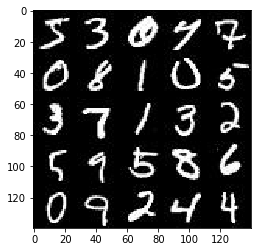

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

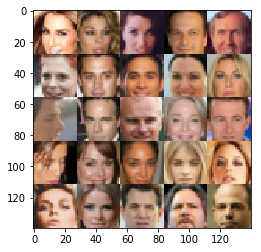

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, shape=[None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # First convolutional layer - 14x14x32
        conv_layer = tf.layers.conv2d(images, 32, kernel_size=5, strides=2, padding='same')
        conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
        
        # Second convolutional layer - 7x764
        conv_layer = tf.layers.conv2d(conv_layer, 64, kernel_size=5, strides=2, padding='same')
        conv_layer = tf.layers.batch_normalization(conv_layer, training=True)
        conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
        
        # Third convolutional layer - 4x4x128
        conv_layer = tf.layers.conv2d(conv_layer, 128, kernel_size=5, strides=2, padding='same')
        conv_layer = tf.layers.batch_normalization(conv_layer, training=True)
        conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
        
        # Output
        flat = tf.reshape(conv_layer, (-1, 4 * 4 * 128))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # Fully connected layer
        fc = tf.layers.dense(z, 4 * 4 * 128)
        
        # Reshape
        layer = tf.reshape(fc, (-1, 4, 4, 128))
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(alpha * layer, layer)
        
        # First convolutional layer - 7x7x64
        conv_layer = tf.layers.conv2d_transpose(layer, 64, kernel_size=4, strides=1, padding='valid')
        conv_layer = tf.layers.batch_normalization(conv_layer, training=is_train)
        conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
        
        # Second convolutional layer - 14x14x32
        conv_layer = tf.layers.conv2d_transpose(conv_layer, 32, kernel_size=5, strides=2, padding='same')
        conv_layer = tf.layers.batch_normalization(conv_layer, training=is_train)
        conv_layer = tf.maximum(alpha * conv_layer, conv_layer)
        
        # Third convolutional layer - 28x28x3
        conv_layer = tf.layers.conv2d_transpose(conv_layer, out_channel_dim, kernel_size=5, strides=2, padding='same')        
        
        # Output
        out = tf.tanh(conv_layer)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [25]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
        
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.2):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, img_height, img_width, img_channel = data_shape    
    inputs_real, inputs_z, lr = model_inputs(img_height, img_width, img_channel, z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, img_channel, alpha)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    losses = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Convert the images values from -.5, .5 to -1, 1
                batch_images *= 2
                
                batch_z = np.random.uniform(-1, 1, size=[batch_size, z_dim])
                
                # Run optimizers
                sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr: learning_rate})
                                
                # Show the loss every 10 steps
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({inputs_real: batch_images, inputs_z: batch_z})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print('Epoch: {}/{}'.format(epoch_i + 1, epoch_count),
                          'Discriminator Loss: {}'.format(train_loss_d),
                          'Generator Loss: {}'.format(train_loss_g))
                    
                    # Save the losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                # Show the generator ouput every 100 steps
                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)
    
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2 Discriminator Loss: 0.36813783645629883 Generator Loss: 1.6216150522232056
Epoch: 1/2 Discriminator Loss: 0.1686749905347824 Generator Loss: 2.5546228885650635
Epoch: 1/2 Discriminator Loss: 0.09130242466926575 Generator Loss: 3.1639699935913086
Epoch: 1/2 Discriminator Loss: 0.1943395733833313 Generator Loss: 2.215421199798584
Epoch: 1/2 Discriminator Loss: 0.24528729915618896 Generator Loss: 1.6916520595550537
Epoch: 1/2 Discriminator Loss: 0.2002236694097519 Generator Loss: 2.4814906120300293
Epoch: 1/2 Discriminator Loss: 0.2565895617008209 Generator Loss: 2.0374953746795654
Epoch: 1/2 Discriminator Loss: 0.7117294073104858 Generator Loss: 1.0463292598724365
Epoch: 1/2 Discriminator Loss: 0.23461119830608368 Generator Loss: 2.2762181758880615
Epoch: 1/2 Discriminator Loss: 0.16245517134666443 Generator Loss: 2.3581628799438477


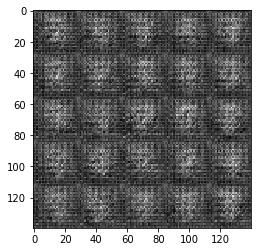

Epoch: 1/2 Discriminator Loss: 0.16520974040031433 Generator Loss: 2.5892462730407715
Epoch: 1/2 Discriminator Loss: 0.1386706680059433 Generator Loss: 2.495394229888916
Epoch: 1/2 Discriminator Loss: 0.09090861678123474 Generator Loss: 3.7018303871154785
Epoch: 1/2 Discriminator Loss: 0.17532974481582642 Generator Loss: 2.584390640258789
Epoch: 1/2 Discriminator Loss: 0.15487663447856903 Generator Loss: 2.9347219467163086
Epoch: 1/2 Discriminator Loss: 2.5284621715545654 Generator Loss: 10.931798934936523
Epoch: 1/2 Discriminator Loss: 0.33968985080718994 Generator Loss: 3.5350465774536133
Epoch: 1/2 Discriminator Loss: 1.24568510055542 Generator Loss: 5.34343957901001
Epoch: 1/2 Discriminator Loss: 0.40516889095306396 Generator Loss: 1.9924219846725464
Epoch: 1/2 Discriminator Loss: 0.2377718836069107 Generator Loss: 2.2737436294555664


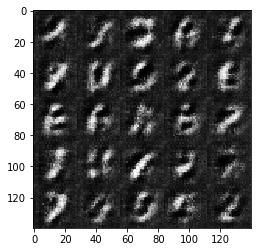

Epoch: 1/2 Discriminator Loss: 0.2513337731361389 Generator Loss: 3.0970215797424316
Epoch: 1/2 Discriminator Loss: 1.8314313888549805 Generator Loss: 0.34349149465560913
Epoch: 1/2 Discriminator Loss: 0.3008323013782501 Generator Loss: 2.056842803955078
Epoch: 1/2 Discriminator Loss: 1.1631165742874146 Generator Loss: 0.5487939119338989
Epoch: 1/2 Discriminator Loss: 0.49511465430259705 Generator Loss: 1.2557594776153564
Epoch: 1/2 Discriminator Loss: 0.9224320650100708 Generator Loss: 0.6801052689552307
Epoch: 1/2 Discriminator Loss: 0.292645663022995 Generator Loss: 2.842296600341797
Epoch: 1/2 Discriminator Loss: 3.6469178199768066 Generator Loss: 0.035273246467113495
Epoch: 1/2 Discriminator Loss: 0.36316055059432983 Generator Loss: 2.082571029663086
Epoch: 1/2 Discriminator Loss: 0.4427785873413086 Generator Loss: 1.3050999641418457


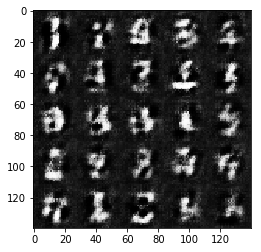

Epoch: 1/2 Discriminator Loss: 1.9911198616027832 Generator Loss: 0.20295047760009766
Epoch: 1/2 Discriminator Loss: 0.35276520252227783 Generator Loss: 2.034602642059326
Epoch: 1/2 Discriminator Loss: 0.34709566831588745 Generator Loss: 2.0793492794036865
Epoch: 1/2 Discriminator Loss: 0.39052289724349976 Generator Loss: 1.4845852851867676
Epoch: 1/2 Discriminator Loss: 0.28733304142951965 Generator Loss: 2.3004841804504395
Epoch: 1/2 Discriminator Loss: 0.6967288255691528 Generator Loss: 0.8480530977249146
Epoch: 1/2 Discriminator Loss: 0.4767031967639923 Generator Loss: 1.198254942893982
Epoch: 1/2 Discriminator Loss: 0.28091925382614136 Generator Loss: 2.2105305194854736
Epoch: 1/2 Discriminator Loss: 0.4847891926765442 Generator Loss: 1.5585248470306396
Epoch: 1/2 Discriminator Loss: 0.925236165523529 Generator Loss: 0.6464499831199646


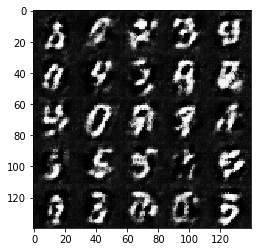

Epoch: 1/2 Discriminator Loss: 0.3960067629814148 Generator Loss: 1.6766505241394043
Epoch: 1/2 Discriminator Loss: 0.2868387699127197 Generator Loss: 2.3234267234802246
Epoch: 1/2 Discriminator Loss: 0.5716426372528076 Generator Loss: 3.522368907928467
Epoch: 1/2 Discriminator Loss: 0.40113189816474915 Generator Loss: 1.5400969982147217
Epoch: 1/2 Discriminator Loss: 0.30966001749038696 Generator Loss: 1.7770369052886963
Epoch: 1/2 Discriminator Loss: 0.8712281584739685 Generator Loss: 0.652946949005127
Epoch: 1/2 Discriminator Loss: 0.5634849071502686 Generator Loss: 1.143080472946167
Epoch: 1/2 Discriminator Loss: 0.529390811920166 Generator Loss: 1.2530131340026855
Epoch: 1/2 Discriminator Loss: 0.3701958656311035 Generator Loss: 1.5477139949798584
Epoch: 1/2 Discriminator Loss: 0.4276336133480072 Generator Loss: 3.227867841720581


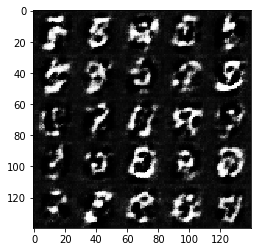

Epoch: 1/2 Discriminator Loss: 0.9206476807594299 Generator Loss: 0.6539773941040039
Epoch: 1/2 Discriminator Loss: 0.4905097186565399 Generator Loss: 2.994241714477539
Epoch: 1/2 Discriminator Loss: 0.7380033731460571 Generator Loss: 3.633056163787842
Epoch: 1/2 Discriminator Loss: 0.29630059003829956 Generator Loss: 2.2071902751922607
Epoch: 1/2 Discriminator Loss: 0.346291184425354 Generator Loss: 1.9565926790237427
Epoch: 1/2 Discriminator Loss: 0.587608277797699 Generator Loss: 3.363049268722534
Epoch: 1/2 Discriminator Loss: 0.5136886239051819 Generator Loss: 1.217815637588501
Epoch: 1/2 Discriminator Loss: 0.34800004959106445 Generator Loss: 1.855771780014038
Epoch: 1/2 Discriminator Loss: 0.385555624961853 Generator Loss: 1.6213852167129517
Epoch: 1/2 Discriminator Loss: 0.3956093192100525 Generator Loss: 2.7262368202209473


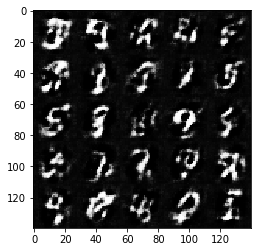

Epoch: 1/2 Discriminator Loss: 1.5139766931533813 Generator Loss: 5.2414960861206055
Epoch: 1/2 Discriminator Loss: 0.2932021915912628 Generator Loss: 2.441981315612793
Epoch: 1/2 Discriminator Loss: 0.4079132676124573 Generator Loss: 2.017822027206421
Epoch: 1/2 Discriminator Loss: 0.244490846991539 Generator Loss: 2.333296537399292
Epoch: 1/2 Discriminator Loss: 0.4208027422428131 Generator Loss: 1.5826852321624756
Epoch: 1/2 Discriminator Loss: 0.8129405975341797 Generator Loss: 0.7717206478118896
Epoch: 1/2 Discriminator Loss: 0.3843153417110443 Generator Loss: 1.5932021141052246
Epoch: 1/2 Discriminator Loss: 0.8299026489257812 Generator Loss: 0.7469191551208496
Epoch: 1/2 Discriminator Loss: 0.29240530729293823 Generator Loss: 2.0515124797821045
Epoch: 1/2 Discriminator Loss: 0.3160812556743622 Generator Loss: 1.8534550666809082


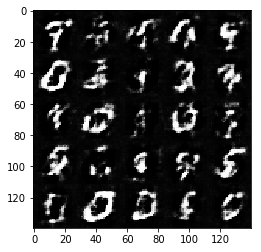

Epoch: 1/2 Discriminator Loss: 1.2019755840301514 Generator Loss: 0.5104320049285889
Epoch: 1/2 Discriminator Loss: 0.3012675940990448 Generator Loss: 1.9208523035049438
Epoch: 1/2 Discriminator Loss: 0.3235965967178345 Generator Loss: 1.8267250061035156
Epoch: 1/2 Discriminator Loss: 0.425668865442276 Generator Loss: 3.548794984817505
Epoch: 1/2 Discriminator Loss: 0.9974430799484253 Generator Loss: 4.470481872558594
Epoch: 1/2 Discriminator Loss: 0.32178354263305664 Generator Loss: 1.9380109310150146
Epoch: 1/2 Discriminator Loss: 1.0739986896514893 Generator Loss: 0.6117459535598755
Epoch: 1/2 Discriminator Loss: 0.47052252292633057 Generator Loss: 1.5117237567901611
Epoch: 1/2 Discriminator Loss: 0.3843063712120056 Generator Loss: 1.7140427827835083
Epoch: 1/2 Discriminator Loss: 0.35525909066200256 Generator Loss: 1.8905383348464966


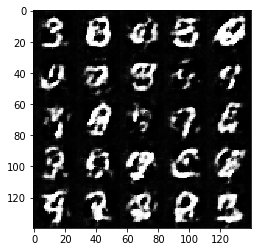

Epoch: 1/2 Discriminator Loss: 0.37729930877685547 Generator Loss: 3.1385178565979004
Epoch: 1/2 Discriminator Loss: 0.7496979236602783 Generator Loss: 3.802401304244995
Epoch: 1/2 Discriminator Loss: 0.3009193539619446 Generator Loss: 1.98287034034729
Epoch: 1/2 Discriminator Loss: 0.504978358745575 Generator Loss: 3.492338180541992
Epoch: 1/2 Discriminator Loss: 0.4658418595790863 Generator Loss: 1.2607512474060059
Epoch: 1/2 Discriminator Loss: 0.5803982019424438 Generator Loss: 1.107417345046997
Epoch: 1/2 Discriminator Loss: 1.2360625267028809 Generator Loss: 3.6757822036743164
Epoch: 1/2 Discriminator Loss: 0.342489093542099 Generator Loss: 1.8381520509719849
Epoch: 1/2 Discriminator Loss: 0.42796194553375244 Generator Loss: 1.5704083442687988
Epoch: 1/2 Discriminator Loss: 0.36449891328811646 Generator Loss: 1.9188181161880493


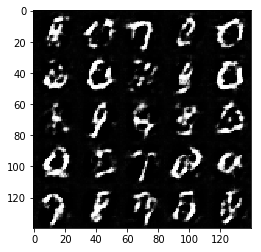

Epoch: 1/2 Discriminator Loss: 0.7291050553321838 Generator Loss: 0.8348350524902344
Epoch: 1/2 Discriminator Loss: 0.2655596137046814 Generator Loss: 1.9969069957733154
Epoch: 1/2 Discriminator Loss: 0.3957808017730713 Generator Loss: 1.9293376207351685
Epoch: 2/2 Discriminator Loss: 0.3762356638908386 Generator Loss: 1.9327493906021118
Epoch: 2/2 Discriminator Loss: 0.3301909267902374 Generator Loss: 1.9448097944259644
Epoch: 2/2 Discriminator Loss: 0.3594016134738922 Generator Loss: 1.999306321144104
Epoch: 2/2 Discriminator Loss: 1.3644050359725952 Generator Loss: 0.3866315484046936
Epoch: 2/2 Discriminator Loss: 0.4632294178009033 Generator Loss: 1.431670069694519
Epoch: 2/2 Discriminator Loss: 1.7634493112564087 Generator Loss: 4.517848968505859
Epoch: 2/2 Discriminator Loss: 0.4188677966594696 Generator Loss: 1.6662046909332275


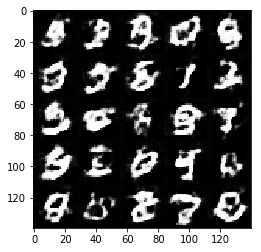

Epoch: 2/2 Discriminator Loss: 0.5668920278549194 Generator Loss: 1.1281535625457764
Epoch: 2/2 Discriminator Loss: 0.30433112382888794 Generator Loss: 2.010962963104248
Epoch: 2/2 Discriminator Loss: 0.36957570910453796 Generator Loss: 2.113105297088623
Epoch: 2/2 Discriminator Loss: 1.1889374256134033 Generator Loss: 3.578524589538574
Epoch: 2/2 Discriminator Loss: 0.3824969530105591 Generator Loss: 2.137498140335083
Epoch: 2/2 Discriminator Loss: 0.4377337694168091 Generator Loss: 1.4978729486465454
Epoch: 2/2 Discriminator Loss: 1.305817723274231 Generator Loss: 0.4479773938655853
Epoch: 2/2 Discriminator Loss: 0.4614860415458679 Generator Loss: 1.4962420463562012
Epoch: 2/2 Discriminator Loss: 0.6143606901168823 Generator Loss: 0.972254753112793
Epoch: 2/2 Discriminator Loss: 0.5326642990112305 Generator Loss: 1.2687952518463135


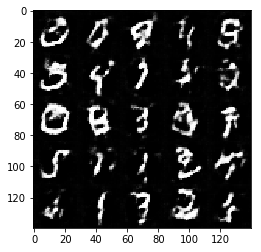

Epoch: 2/2 Discriminator Loss: 0.377506285905838 Generator Loss: 3.59592342376709
Epoch: 2/2 Discriminator Loss: 0.5585967302322388 Generator Loss: 2.540621042251587
Epoch: 2/2 Discriminator Loss: 0.523603618144989 Generator Loss: 1.2654427289962769
Epoch: 2/2 Discriminator Loss: 0.3789379298686981 Generator Loss: 2.169250726699829
Epoch: 2/2 Discriminator Loss: 0.532568097114563 Generator Loss: 1.307779312133789
Epoch: 2/2 Discriminator Loss: 1.0674136877059937 Generator Loss: 0.6631065607070923
Epoch: 2/2 Discriminator Loss: 0.38019877672195435 Generator Loss: 2.189319610595703
Epoch: 2/2 Discriminator Loss: 0.7453596591949463 Generator Loss: 0.8618643283843994
Epoch: 2/2 Discriminator Loss: 0.43235430121421814 Generator Loss: 1.618378758430481
Epoch: 2/2 Discriminator Loss: 0.34880203008651733 Generator Loss: 1.9909471273422241


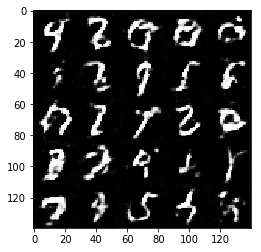

Epoch: 2/2 Discriminator Loss: 0.4133974313735962 Generator Loss: 1.5575851202011108
Epoch: 2/2 Discriminator Loss: 0.6532109975814819 Generator Loss: 2.715268850326538
Epoch: 2/2 Discriminator Loss: 0.5682379007339478 Generator Loss: 1.2751007080078125
Epoch: 2/2 Discriminator Loss: 0.5251748561859131 Generator Loss: 1.326833724975586
Epoch: 2/2 Discriminator Loss: 0.6818290948867798 Generator Loss: 3.1662192344665527
Epoch: 2/2 Discriminator Loss: 1.556838035583496 Generator Loss: 4.461151123046875
Epoch: 2/2 Discriminator Loss: 0.6897975206375122 Generator Loss: 0.9714088439941406
Epoch: 2/2 Discriminator Loss: 0.6254432797431946 Generator Loss: 1.043269157409668
Epoch: 2/2 Discriminator Loss: 0.3435596823692322 Generator Loss: 1.8733468055725098
Epoch: 2/2 Discriminator Loss: 1.0872435569763184 Generator Loss: 0.5233034491539001


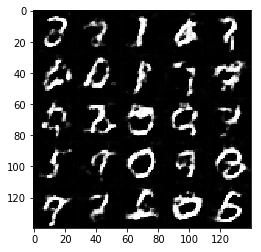

Epoch: 2/2 Discriminator Loss: 0.49313730001449585 Generator Loss: 2.1589694023132324
Epoch: 2/2 Discriminator Loss: 1.3462036848068237 Generator Loss: 3.5519473552703857
Epoch: 2/2 Discriminator Loss: 0.38118913769721985 Generator Loss: 2.6571884155273438
Epoch: 2/2 Discriminator Loss: 0.34500348567962646 Generator Loss: 1.8489004373550415
Epoch: 2/2 Discriminator Loss: 0.6659538745880127 Generator Loss: 1.4348686933517456
Epoch: 2/2 Discriminator Loss: 0.38635334372520447 Generator Loss: 1.870661973953247
Epoch: 2/2 Discriminator Loss: 0.43819963932037354 Generator Loss: 2.4475300312042236
Epoch: 2/2 Discriminator Loss: 0.3810657262802124 Generator Loss: 1.7998809814453125
Epoch: 2/2 Discriminator Loss: 0.4157959818840027 Generator Loss: 2.7571215629577637
Epoch: 2/2 Discriminator Loss: 0.7322692275047302 Generator Loss: 0.8865994811058044


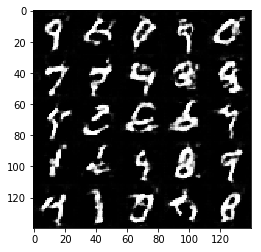

Epoch: 2/2 Discriminator Loss: 0.517407238483429 Generator Loss: 1.7074577808380127
Epoch: 2/2 Discriminator Loss: 0.5131359100341797 Generator Loss: 1.3060405254364014
Epoch: 2/2 Discriminator Loss: 0.5783361792564392 Generator Loss: 1.560064435005188
Epoch: 2/2 Discriminator Loss: 0.37453633546829224 Generator Loss: 1.7118096351623535
Epoch: 2/2 Discriminator Loss: 0.6197080612182617 Generator Loss: 2.264349937438965
Epoch: 2/2 Discriminator Loss: 0.5107589364051819 Generator Loss: 1.297234296798706
Epoch: 2/2 Discriminator Loss: 0.41930508613586426 Generator Loss: 1.6914150714874268
Epoch: 2/2 Discriminator Loss: 0.48752400279045105 Generator Loss: 1.5114738941192627
Epoch: 2/2 Discriminator Loss: 0.5471256971359253 Generator Loss: 1.1413295269012451
Epoch: 2/2 Discriminator Loss: 0.3793278634548187 Generator Loss: 1.5965511798858643


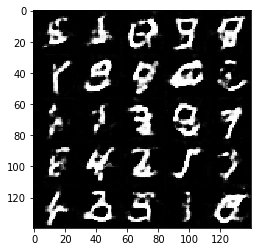

Epoch: 2/2 Discriminator Loss: 0.5791953802108765 Generator Loss: 1.115208387374878
Epoch: 2/2 Discriminator Loss: 0.36003172397613525 Generator Loss: 1.749584674835205
Epoch: 2/2 Discriminator Loss: 0.3589933514595032 Generator Loss: 2.0529866218566895
Epoch: 2/2 Discriminator Loss: 0.3060111999511719 Generator Loss: 2.1078057289123535
Epoch: 2/2 Discriminator Loss: 0.37754374742507935 Generator Loss: 1.9122047424316406
Epoch: 2/2 Discriminator Loss: 0.541892409324646 Generator Loss: 1.9949755668640137
Epoch: 2/2 Discriminator Loss: 0.5543150305747986 Generator Loss: 1.210975170135498
Epoch: 2/2 Discriminator Loss: 0.5707966089248657 Generator Loss: 1.1943418979644775
Epoch: 2/2 Discriminator Loss: 0.45912328362464905 Generator Loss: 1.5647588968276978
Epoch: 2/2 Discriminator Loss: 0.4768139123916626 Generator Loss: 1.8996191024780273


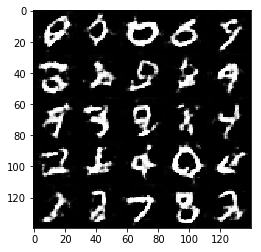

Epoch: 2/2 Discriminator Loss: 0.6580716967582703 Generator Loss: 0.9826982021331787
Epoch: 2/2 Discriminator Loss: 0.844424307346344 Generator Loss: 3.0063843727111816
Epoch: 2/2 Discriminator Loss: 0.4319145083427429 Generator Loss: 1.7239396572113037
Epoch: 2/2 Discriminator Loss: 0.5003466010093689 Generator Loss: 1.231708288192749
Epoch: 2/2 Discriminator Loss: 0.42368948459625244 Generator Loss: 1.3769958019256592
Epoch: 2/2 Discriminator Loss: 0.4335639476776123 Generator Loss: 1.4409111738204956
Epoch: 2/2 Discriminator Loss: 0.3639012277126312 Generator Loss: 1.8945786952972412
Epoch: 2/2 Discriminator Loss: 0.37691420316696167 Generator Loss: 2.0572123527526855
Epoch: 2/2 Discriminator Loss: 0.3312813937664032 Generator Loss: 1.8653695583343506
Epoch: 2/2 Discriminator Loss: 0.527657151222229 Generator Loss: 1.2687033414840698


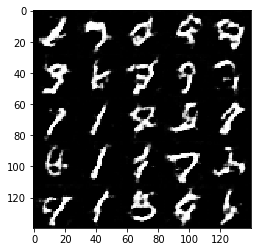

Epoch: 2/2 Discriminator Loss: 0.5734993815422058 Generator Loss: 1.3003418445587158
Epoch: 2/2 Discriminator Loss: 0.5445825457572937 Generator Loss: 1.36155104637146
Epoch: 2/2 Discriminator Loss: 0.49442994594573975 Generator Loss: 1.3658133745193481
Epoch: 2/2 Discriminator Loss: 0.47368037700653076 Generator Loss: 2.4899394512176514
Epoch: 2/2 Discriminator Loss: 0.6452693343162537 Generator Loss: 1.0454976558685303
Epoch: 2/2 Discriminator Loss: 0.2823355793952942 Generator Loss: 2.047969341278076
Epoch: 2/2 Discriminator Loss: 0.4550662636756897 Generator Loss: 1.3593411445617676
Epoch: 2/2 Discriminator Loss: 1.469804286956787 Generator Loss: 0.43460017442703247
Epoch: 2/2 Discriminator Loss: 0.42982155084609985 Generator Loss: 2.570481300354004
Epoch: 2/2 Discriminator Loss: 0.4316324293613434 Generator Loss: 1.5634894371032715


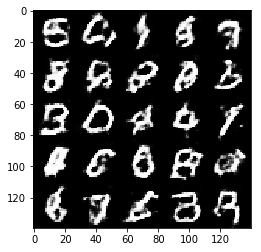

Epoch: 2/2 Discriminator Loss: 0.6023796796798706 Generator Loss: 2.089860439300537
Epoch: 2/2 Discriminator Loss: 0.6647155284881592 Generator Loss: 1.031968593597412
Epoch: 2/2 Discriminator Loss: 0.42509526014328003 Generator Loss: 1.6008657217025757
Epoch: 2/2 Discriminator Loss: 0.4202822744846344 Generator Loss: 1.810642957687378
Epoch: 2/2 Discriminator Loss: 0.549281656742096 Generator Loss: 1.4891865253448486
Epoch: 2/2 Discriminator Loss: 0.45832353830337524 Generator Loss: 1.9191274642944336
Epoch: 2/2 Discriminator Loss: 0.34964728355407715 Generator Loss: 1.7553339004516602


In [29]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.4
alpha = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

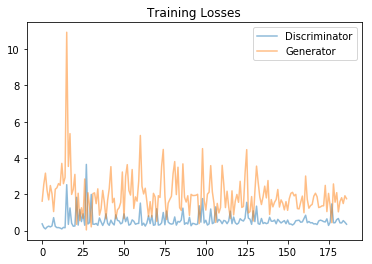

In [30]:
import matplotlib.pylab as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = None
z_dim = None
learning_rate = None
beta1 = None


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.